In [1]:
import xarray as xr

import seaduck as sd
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

from itertools import accumulate

import os
from matplotlib.patches import Patch
import sys
sys.path.append('/home/wjiang33/parallel_run/seaduck_post_process/')
from post_process.estimate import *
# from post_process.region import *

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import matplotlib.ticker as mticker

In [4]:
a_palette5 = ["#003049","#61988e","#f77f00","#7d1538","#345511"]
region_names =['gulf','labr','gdbk','nace','egrl']
region_longnames = ['Gulf Stream','Labrador Current','Grand Bank','NAC Extension','East Greenland Current']
region_longnames = dict(zip(region_names, region_longnames))
region_colors = dict(zip(region_names,a_palette5))

In [5]:
from matplotlib.gridspec import GridSpec

In [6]:
GULF = np.array([
    [-92.5,25],
    [-75,25],
    [-55,40],
    [-72.5,40],
])
LABR = np.array([
    [-72,63.5],
    [-60, 50],
    [-49,53],
    [-61,66.5]
])
GDBK = np.array([
    # GULF[2],
    GULF[3],
    LABR[1],
    LABR[2],
    [-42,50],
    [-42,40],
])
NACE = np.array([
    GDBK[-2],
    GDBK[-1],
    [-21,47],
    [-21,57]
])
EGRL = np.array([
    [-22.5,72],
    [-44,63],
    [-44,57],
    [-22.5,66]
])

In [7]:
from matplotlib.dates import date2num, num2date
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.path as mpath
from tqdm import tqdm

In [8]:
import plot_config
reload(plot_config)

from plot_config import *

In [9]:
from utils import *

In [10]:
ecco_grid = xr.open_zarr('~/ECCO_transport')

In [11]:
xg = np.load('plotting_xg.npy')
yg = np.load('plotting_yg.npy')

In [12]:
rerun = False

In [13]:
loadbox_plot4 = xr.open_zarr('lineplotprep/box_plot4')
loadbox_plota = xr.open_zarr('lineplotprep/box_plota')
box_plot4 = {}
for var in loadbox_plot4:
    box_plot4[var] = np.array(loadbox_plot4[var])/NUMBER_OF_PARTICLE_domain4*365.25*10
box_plota = {}
for var in loadbox_plota:
    box_plota[var] = np.array(loadbox_plota[var])/NUMBER_OF_PARTICLE_domain_all*365.25*10

In [14]:
lons = np.load('lineplotprep/mean_lons.npy')
lats = np.load('lineplotprep/mean_lats.npy')

In [15]:
lons.shape

(3649, 2000)

In [16]:
xrange = (-34,-10)
yrange = (47.5,65)
zrange = (-200,0)

xbounds = np.linspace(xrange[0],xrange[1],4)
ybounds = np.linspace(np.sin(yrange[0]*np.pi/180), np.sin(yrange[1]*np.pi/180),4)
xbnds = []
ybnds = []
for i in range(3):
    for j in range(3):
        xbnds.append((xbounds[i],xbounds[i+1]))
        ybnds.append((np.arcsin(ybounds[j])*180/np.pi,np.arcsin(ybounds[j+1])*180/np.pi))

cxrange = xbnds[4]
cyrange = ybnds[4]

In [17]:
poly_large = poly_from_xyrange(xrange,yrange)
poly_center = poly_from_xyrange(cxrange,cyrange)

In [19]:
from utils import *
ds4 = open_domain4()
dsa = open_domain_all()

In [20]:
just_for_time = '/sciserver/filedb10-01/ocean/wenrui_temp/vol_budget'

rtime = np.array(xr.open_zarr(just_for_time).time)
ptime = np.linspace(0,3655,3650)/365
salty_time = rtime[salty_idate - np.arange(len(ptime))]
fresh_time = rtime[fresh_idate - np.arange(len(ptime))]

In [21]:
def mean_stream_plot(
    lats,
    lons,
    times,
    projection,
    particle_bins=1,
    axs = None,
    cmap = 'bwr',
    extent = None,
    darken = 1.0,
    alpha = 1.0,
    plot_num = "(a)"
    # bins=5,
    # north=1000,
    # south=-1000,
    # plot_lines=True,
):
    spds = times
    # axs.set_facecolor("lightgrey")
    # axs.add_feature(cf.LAND, zorder=10, facecolor='grey')
    for i in [2,6,10]:
        pp = axs.pcolormesh(xg[i],yg[i],ecco_grid.Depth[i], 
                       cmap = depth_cmap, norm = depth_norm,transform = ccrs.PlateCarree(),
                            linewidth=0,rasterized=True)
        pp.set_edgecolor('face')
    axs.coastlines(color = 'w',resolution = '50m')
    if extent is not None:
        axs.set_extent(extent)
    n = 20
    aoi = mpath.Path(
        list(zip(np.linspace(extent[0],extent[1], n), np.full(n, extent[3]))) + \
        list(zip(np.full(n, extent[1]), np.linspace(extent[3], extent[2], n))) + \
        list(zip(np.linspace(extent[1], extent[0], n), np.full(n, extent[2]))) + \
        list(zip(np.full(n, extent[0]), np.linspace(extent[2], extent[3], n)))
    )
    axs.set_boundary(aoi, transform=ccrs.PlateCarree())
    plt.tight_layout()
    # To speed up the computation, we transform the
    # latlon outside the for plotting for-loop.
    xx, yy, _ = projection.transform_points(ccrs.PlateCarree(), lons, lats).T

    xx = xx.T
    yy = yy.T
    
    norm = plt.Normalize(-3650,0)
    

    for i in tqdm(range(0, lons.shape[1], particle_bins)):
        y = yy.T[i][1:]
        x = xx.T[i][1:]
        if np.max(x) - np.min(x) > 300:
            x[x < 0] += 360
        dydx = (0.5 * (spds[:-1] + spds[1:]))[1:]  # first derivative

        # Create a set of line segments so that we can color them individually
        # This creates the points as a N x 1 x 2 array so that we can stack points
        # together easily to get the segments. The segments array for line collection
        # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)

        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a continuous norm to map from data points to colors
        lc = LineCollection(segments, cmap=cmap, norm=norm,lw = 0.01,alpha = alpha,zorder=1,rasterized = True)
        # Set the values used for colormapping
        lc.set_array(dydx)
        lc.set_linewidth(0.3)
        axs.add_collection(lc)
    divider = make_axes_locatable(axs)
    # cax = divider.append_axes("left", size="5%", pad=0.05)
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, location = 'left',aspect = 50,fraction = 0.04,shrink = 1)
    date_ticks = np.arange(-10, 1)*365
    labels = [str(-i//365) + 'ya' for i in date_ticks]
    cbar.set_ticks(date_ticks)
    cbar.set_ticklabels(labels)
    cbar.ax.text(1.05, 1.02, plot_num, transform=cbar.ax.transAxes, ha="right", va="bottom")

    nside = 6
    for reg in region_names:
        reg_color = region_colors[reg]
        poly = eval(reg.upper())
        xs,ys = poly.T
        xs = list(xs)+[xs[0]]
        ys = list(ys)+[ys[0]]
        for i in range(len(poly)):
            lx = np.linspace(xs[i],xs[i+1], nside)
            ly = np.linspace(ys[i],ys[i+1], nside)
            axs.plot(lx,ly,c = reg_color,transform = ccrs.PlateCarree(),lw = 2.5)
    for poly, style in zip([poly_large,poly_center],[{'c':'cyan','linestyle':'--'},{'c':'cyan','linestyle':'-'}]):
        xs,ys = poly.T
        xs = list(xs)+[xs[0]]
        ys = list(ys)+[ys[0]]
        for i in range(len(poly)):
            lx = np.linspace(xs[i],xs[i+1], nside)
            ly = np.linspace(ys[i],ys[i+1], nside)
            # print('how')
            axs.plot(lx,ly,transform = ccrs.PlateCarree(),**style)
    return plt.gca()

In [22]:
def box_on_ax(ax,a_region,shrink):

    labels = [term_dic[var] for var in rhs_list]
    data4 = [-box_plot4[var+'_'+a_region] for var in rhs_list]
    dataa = [-box_plota[var+'_'+a_region] for var in rhs_list]
    colors = [color_dic[var] for var in rhs_list]
    
    # Width of the bars
    bar_width = 0.35
    
    # Set up positions for bars
    positions1 = np.arange(len(labels))
    positions2 = positions1 + bar_width
    
    # thing = plt.boxplot(data, labels=labels, patch_artist=True,showfliers = False)
    thing1 = ax.boxplot(data4, positions=positions1, widths=bar_width, patch_artist=True,showfliers = False,showmeans = True,meanline = True, whis = [2.5,97.5])
    thing2 = ax.boxplot(dataa, positions=positions2, widths=bar_width, patch_artist=True,showfliers = False,showmeans = True,meanline = True, whis = [2.5,97.5])
    
    for patch, color in zip(thing1['boxes'], colors):
        patch.set_facecolor(color)
    
    for patch, color in zip(thing2['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_hatch('//')
    for meanline in thing1['means']:
        meanline.set_color('black')
    for meanline in thing2['means']:
        meanline.set_color('black')
    for medianline in thing1['medians']:
        medianline.set_color('black')
    for medianline in thing2['medians']:
        medianline.set_color('black')
    
    # ax.set_xticks(positions1 + bar_width / 2, labels,fontsize = 7*shrink,rotation = 30)
    ax.set_xticks([])
    var_handles = [Patch(facecolor=color, edgecolor='black')
                      for j,color in enumerate(colors)]
    domain_handles = [Patch(facecolor='w', edgecolor='black', hatch = h)
                      for h in ['','//']]
    lgd_labels = labels+['Center Domain','Whole Domain']+['Mean', 'Median']
    # plt.legend(labels = lgd_labels, handles = var_handles+domain_handles+[meanline,medianline],fontsize = 6)
    
    # ax = plt.gca()
    tcolor = region_colors[a_region]
    ax.tick_params(color=tcolor, labelcolor=tcolor)
    y_ticks = ax.get_yticks()
    y_ticks = np.round(y_ticks*10)/10
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks, fontsize=12*shrink)
    for spine in ax.spines.values():
        spine.set_edgecolor(tcolor)
    # plt.yscale('symlog')
    plt.title(region_longnames[a_region],color = tcolor)
    plt.ylabel('PSU/decade',color = tcolor)#,fontsize = 7*shrink)
    return lgd_labels, var_handles+domain_handles+[meanline,medianline]

In [23]:
def add_subplot_axes(ax,rect,axisbg='none'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],facecolor=axisbg)  # matplotlib 2.0+
    # subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= 1.2*rect[2]**0.5
    y_labelsize *= 1.2*rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)

    
    return subax

In [24]:
times = np.linspace(-3649.5,-0.5,3650)[::-1]

In [25]:
mean_extent = (-125, 50, 12, 90)

In [26]:
region_names

['gulf', 'labr', 'gdbk', 'nace', 'egrl']

In [52]:
titles = [r"$s'$"]+[term_dic[i] for i in rhs_list]

In [84]:
bins = 20
b = slice(None,None,bins)
bb= (b,b)

In [99]:
small = 0.035
aa = 12
svmax = 0.15
vmax0 = 0.5
vmax1 = 0.1
vmax2 = 0.05
ratioa = -1/NUMBER_OF_PARTICLE_domain_all*365.2422
def fill_hov(ax,var,i,xticks = True,yticks = True):
    if 's' in var:
        vmax = svmax
        cmap = s_cmap
        ratio4 = 1
        ratioa = 1
        ax.plot(-ptime,salty_time,'--', color = salty_theme_color,zorder = 10)
        ax.plot(-ptime,fresh_time,'--', color = fresh_theme_color,zorder = 10)
    else:
        ratioa = -1/NUMBER_OF_PARTICLE_domain_all*365.2422
        if i >5:
            vmax = vmax2
        elif i >3:
            vmax = vmax1
        else:
            vmax = vmax0
        cmap = term_cmap
    pp = ax.pcolormesh(-ptime[b],rtime[b],dsa[var][bb]*ratioa,vmax = vmax, vmin = -vmax, cmap = cmap,linewidth=0,rasterized=True)
    pp.set_edgecolor('face')
    ax.set_title(titles[i],fontsize = 10)
    if xticks:
        ax.set_xticks(-np.arange(11), [str(i) for i in range(11)])
    else:
        ax.set_xticks([])
    if not yticks:
        ax.set_yticks([])
    ax.set_xlim(-10,0)

Text(-0.05, 1.0, '(e)')

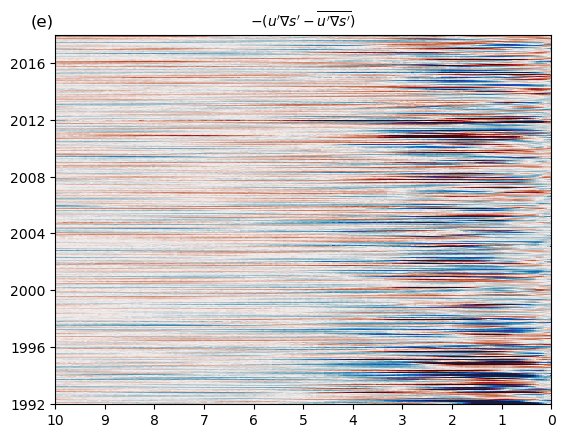

In [98]:
ax = plt.axes()
fill_hov(ax,'E',5)
# plt.colorbar()
ax.set_title('('+chr(97+4+0)+')',x = -0.05,loc = 'left')

In [30]:
small

0.035

In [31]:
offset= -0.0
hspace = 0.37
locs = [
    (0.00,0.3+offset),
    (0.00,0.6+offset),
    (hspace,offset),
    (2*hspace,offset),
    (2*hspace,0.3+offset)
]

In [32]:
space= 0.3
subnum_offset = -0.2

In [34]:
projection = ccrs.LambertConformal(central_longitude=-40, central_latitude=58.0)
extent = (-90, 10, 12, 90)

/tmp/ipykernel_2818236/4051658627.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.71it/s]
/tmp/ipykernel_2818236/2823990511.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(ticklabs, fontsize=6,rotation = 90,va = 'center')
/tmp/ipykernel_2818236/2823990511.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(ticklabs, fontsize=6,rotation = 90,va = 'center')
/tmp/ipykernel_2818236/2823990511.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


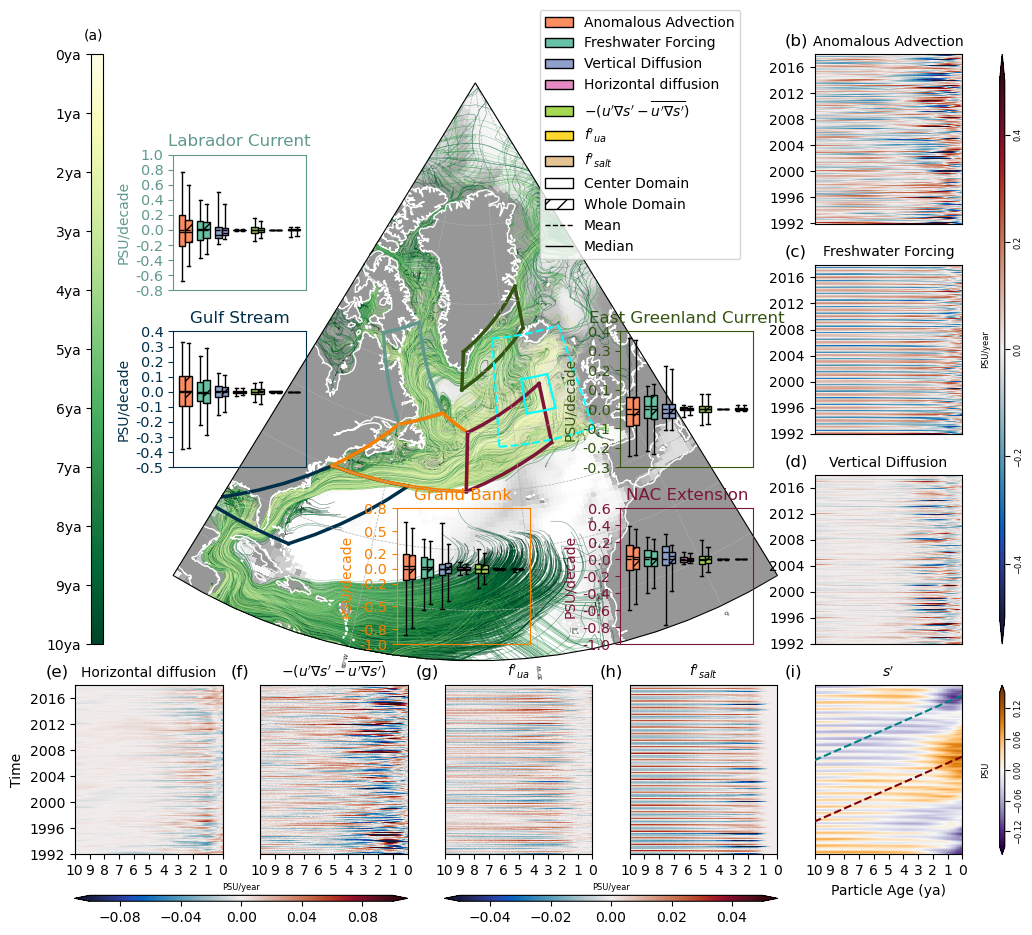

In [101]:
fig = plt.figure(figsize=(12, 11))
gs = GridSpec(5, 6, figure=fig,width_ratios = [1,1,1,1,1,small],height_ratios = [1,1,1,1,small],wspace = space,hspace = space)
ax = fig.add_subplot(gs[:-2, :-2],projection = projection)
mean_stream_plot(
    lats,
    lons,
    times,
    projection,
    axs = ax,
    cmap = mean_time_cmap,
    extent = extent,
    alpha = 0.75,
    # save_as = 'figure7(a)'
)
gl = ax.gridlines(draw_labels={"bottom": "x"}, linestyle="--", linewidth=0.5)
gl.xlabel_style = {'size': 4}  # X-axis grid labels
gl.xlocator = mticker.FixedLocator(np.arange(-8,4)*30)
gl.y_inline = True

gl.x_inline = False
size = (0.22,0.23)
for a_region,loc in zip(region_names,locs):
    subpos = [loc[0],loc[1],size[0],size[1]]
    shrink = np.sqrt(subpos[-1])*1.8
    # if a_region in ['gdbk']:
    #     axisbg = 'none'
    # else:
    #     axisbg = 'w'
    axisbg = 'none'
    ax1 = add_subplot_axes(ax,subpos,axisbg = axisbg)
    lb,hd = box_on_ax(ax1,a_region,shrink)
ax.legend(labels = lb, handles = hd, loc = 'upper right', bbox_to_anchor=(0.95, 1.15))

for i in range(4):
    ax = fig.add_subplot(gs[-2,i])
    if i >0:
        fill_hov(ax,rhs_list[3+i],4+i,yticks = False)
    else:
        fill_hov(ax,rhs_list[3+i],4+i)
        ax.set_ylabel('Time')
    ax.set_title('('+chr(97+4+i)+')',x = subnum_offset,loc = 'left')
for j in range(3):
    ax = fig.add_subplot(gs[j,-2])
    fill_hov(ax,rhs_list[j],1+j,xticks = False)
    ax.set_title('('+chr(97+1+j)+')',x = subnum_offset,loc = 'left')
ax = fig.add_subplot(gs[-2,-2])
fill_hov(ax,'sf',0,yticks = False)
ax.set_title('(i)',x = subnum_offset,loc = 'left')
ax.set_xlabel('Particle Age (ya)')

for (label,vmax,cmap,i,j,location) in [
    ('PSU',svmax,s_cmap,-2,-1,'right'),
    ('PSU/year',vmax0,term_cmap,slice(3),-1,'right'),
    ('PSU/year',vmax1,term_cmap,-1,slice(2),'bottom'),
    ('PSU/year',vmax2,term_cmap,-1,slice(2,4),'bottom'),
]:
    an_axes = plt.subplot(gs[i,j])
    cbar = plt.colorbar(
        cm.ScalarMappable(
            norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax),
            cmap = cmap
        ),
        cax = an_axes,
        extend = 'both',
        location = location,
        aspect = 50,
    )
    cbar.ax.tick_params(axis='y', which='major', pad=3)
    if location  == 'right':
        cbar.ax.set_ylabel(label,labelpad = -30,fontsize = 6)
    else:
        cbar.ax.set_xlabel(label,labelpad = -30,fontsize = 6)
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=6,rotation = 90,va = 'center')
    cbar.locator = mticker.MaxNLocator(nbins=5)  # Limit to 5 tick labels
    cbar.update_ticks() 
plt.tight_layout()
plt.savefig('ng_fig3.pdf', format="pdf",dpi = 300)